# Seminar 2. Text Classification: CNN & RNN

In this seminar, we will continue working with the AG News classification dataset. It contains over 100,000 texts with 4 labels: World, Sports, Business, Sci/Tech. Accordingly, we will be solving a text classification task.

#### Agenda
1. Training convolutional networks on Word2Vec embeddings
    * Simple CNN
    * TextCNN
2. Training RNN on Word2Vec
3. Fine-tuning embeddings together with the model

In [4]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import wandb

wandb.login()

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')
device

device(type='mps')

Let's load the data

In [5]:
data_train = pd.read_csv('data/ag_news_train.csv', sep='\t')
data_test = pd.read_csv('data/ag_news_test.csv', sep='\t')

In [6]:
labels_train = data_train['label']
labels_test = data_test['label']

In [7]:
len(data_train), len(data_test)

(120000, 7600)

In [8]:
X_train = data_train['text'].values
y_train = data_train['label'].values

X_test = data_test['text'].values
y_test = data_test['label'].values

## CNNs

Let's preprocess the data first (like we did it last time):

In [9]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(text: str) -> list[str]:
    """
    Preprocesses input text:
    - tokenizes into words
    - removes stopwords
    - lemmatizes words
    """

    reg = re.compile(r'\w+')
    tokens = reg.findall(text.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return lemmatized_words


In [10]:
X_train[0], preprocess(X_train[0])

("Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 ['wall',
  'st',
  'bear',
  'claw',
  'back',
  'black',
  'reuters',
  'reuters',
  'short',
  'seller',
  'wall',
  'street',
  'dwindling',
  'band',
  'ultra',
  'cynic',
  'seeing',
  'green'])

In [11]:
X_train = [preprocess(sentence) for sentence in X_train]
X_test = [preprocess(sentence) for sentence in X_test]

In [12]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    X_train,
    vector_size=100,
    min_count=4,
    window=5
).wv

In [13]:
def encode_dataset(dataset):
    encoded = []
    for words in dataset:
        vectors = [w2v_model.get_vector(word) for word in words if word in w2v_model]
        encoded.append(torch.from_numpy(np.array(vectors)))

    return encoded

In [14]:
train_embeddings = encode_dataset(X_train)
test_embeddings = encode_dataset(X_test)

Let's evaluate the lengths of the texts. This is necessary to determine what size of model to choose. Convolutional neural networks work best on short texts (up to 20 words). In our case, the texts are longer.

Recall that with TF-IDF last time, we achieved an accuracy of __0.92__. We will use this as a benchmark to compare our model.

Text(0, 0.5, 'Count')

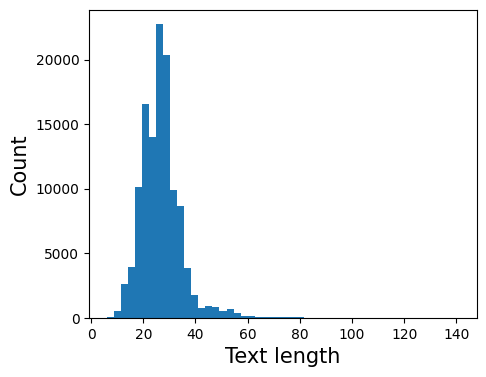

In [15]:
text_lens = [len(x) for x in train_embeddings]

plt.figure(figsize=(5, 4))
plt.hist(text_lens, bins=50);
plt.xlabel('Text length', size=15)
plt.ylabel('Count', size=15)

### Dataset & Dataloader of embeddings

In [16]:
train_dataset = list(zip(train_embeddings, y_train))
test_dataset = list(zip(test_embeddings, y_test))

The `collate_fn` function is called inside the `DataLoader` to process a batch of data. We use it to **pad the texts** so they all have the same length.


In [17]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    x, labels = zip(*batch)
    return pad_sequence(x).permute(1, 0, 2), torch.tensor(labels)

In [18]:
from torch.utils.data import DataLoader

w2v_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
w2v_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

Let's check if the data batch looks correct. We can see that **shorter texts end with zero vectors (paddings)**.

The second element of the batch is the **tensor of target labels**.
Everything looks just as expected!

In [19]:
batch = next(iter(w2v_test_loader))
batch

(tensor([[[ 0.2197, -1.0368, -0.2230,  ...,  0.9307, -0.4339,  2.4268],
          [ 2.5175,  0.2747, -1.0616,  ...,  1.0716,  1.0113, -2.9601],
          [-1.3724, -0.0322, -2.0056,  ...,  0.4988,  1.6800, -1.0134],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.6841,  1.5174, -0.0542,  ..., -2.6576, -2.3955,  1.0660],
          [-0.6153,  1.8998, -1.1776,  ..., -2.5721, -0.2293, -1.0809],
          [-0.0766,  2.1641, -1.5770,  ...,  0.9473, -0.2775,  1.7010],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.2029,  0.0929,  0.2127,  ..., -0.1230,  0.1165, -0.2848],
          [ 0.8003,  1.0626,

### CNN

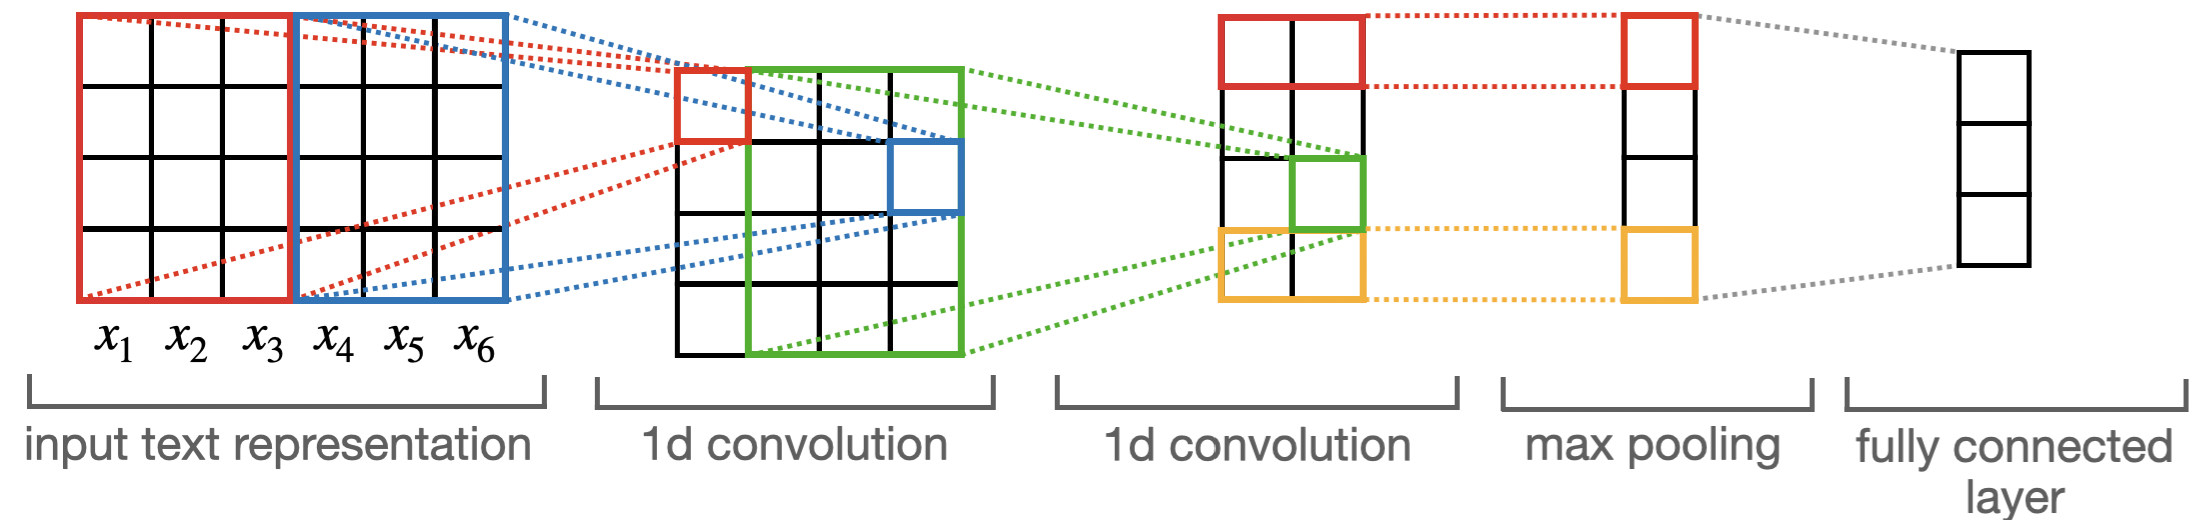

In [20]:
from torch import nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, hid_dim=100, n_classes=4):
        super().__init__()
        
        # не меняем число каналов
        self.conv1 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv1d(hid_dim, hid_dim, kernel_size=3, stride=1, padding=0)

        self.fc = nn.Linear(hid_dim, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: [batch_size, seq_len, dim]
        # меняем местами размерности, так как число каналов (dim) должно стоять на втором месте
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        
        x = F.max_pool1d(x, x.size(-1)).squeeze(dim=-1)
        
        x = self.fc(x)
        return x

In [21]:
def train(model, dataloader, optimizer):
    """
    Обучает модель (model) на всем наборе данных (dataloader).
    """
    
    # не забываем переводить в train режим
    model.train()
    criterion = nn.CrossEntropyLoss()

    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)

        logits = model(tokens)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # логируем значения ошибки и точности
        wandb.log({
            "train_loss": loss.item(),
            "train_accuracy": (logits.argmax(-1) == labels).float().mean().item()
        })


@torch.inference_mode()
def evaluate(model, dataloader):
    """
    Тестирует модель (model) на всем наборе данных (dataloader).
    """
    
    # не забываем переводить в eval режим
    model.eval()
    criterion = nn.CrossEntropyLoss()

    correct = []
    losses = []
    for i, (tokens, labels) in enumerate(dataloader):
        tokens = tokens.to(device)
        labels = labels.to(device)

        logits = model(tokens)
        loss = criterion(logits, labels)

        correct.extend((logits.argmax(-1) == labels).float().cpu())
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    accuracy = np.mean(correct)
    
    # логируем тестовые значения ошибки и точности
    wandb.log({
        "test_loss": mean_loss,
        "test_accuracy": accuracy
    })

    return accuracy, mean_loss

In [22]:
# инициализируем модель и переводим на GPU, если есть
model = SimpleCNN().to(device)

# используем Adam для обучения
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [23]:
wandb.init(project="nlp_lesson2", name="simple_cnn")

In [24]:
# учим в течение 5 эпох
for epoch in range(5):
    train(model, w2v_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader)

wandb.finish()

test_accuracy,▁▄▆▆█
test_loss,█▅▃▂▁
train_accuracy,▂█▁▆▃▄▆▆▆▃▅▃▆▅▆▆▆▆▆▆▆▃▆▄▅▆▅▆▇▄▃▇▆▇▆▅▄▄▆▅
train_loss,▅▆▅▄▆▅▄▄▃▇▇█▃▅▆▆▂▂▃▇▇▅▅▁▃▂▅█▂▃▅▃▅▅▇▇▂▁▅▃
test_accuracy,0.89868
test_loss,0.29784
train_accuracy,0.90625
train_loss,0.24747


In [25]:
print('SimpleCNN')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

SimpleCNN
Test accuracy: 0.8986842
Test loss: 0.2978423894059501


### TextCNN

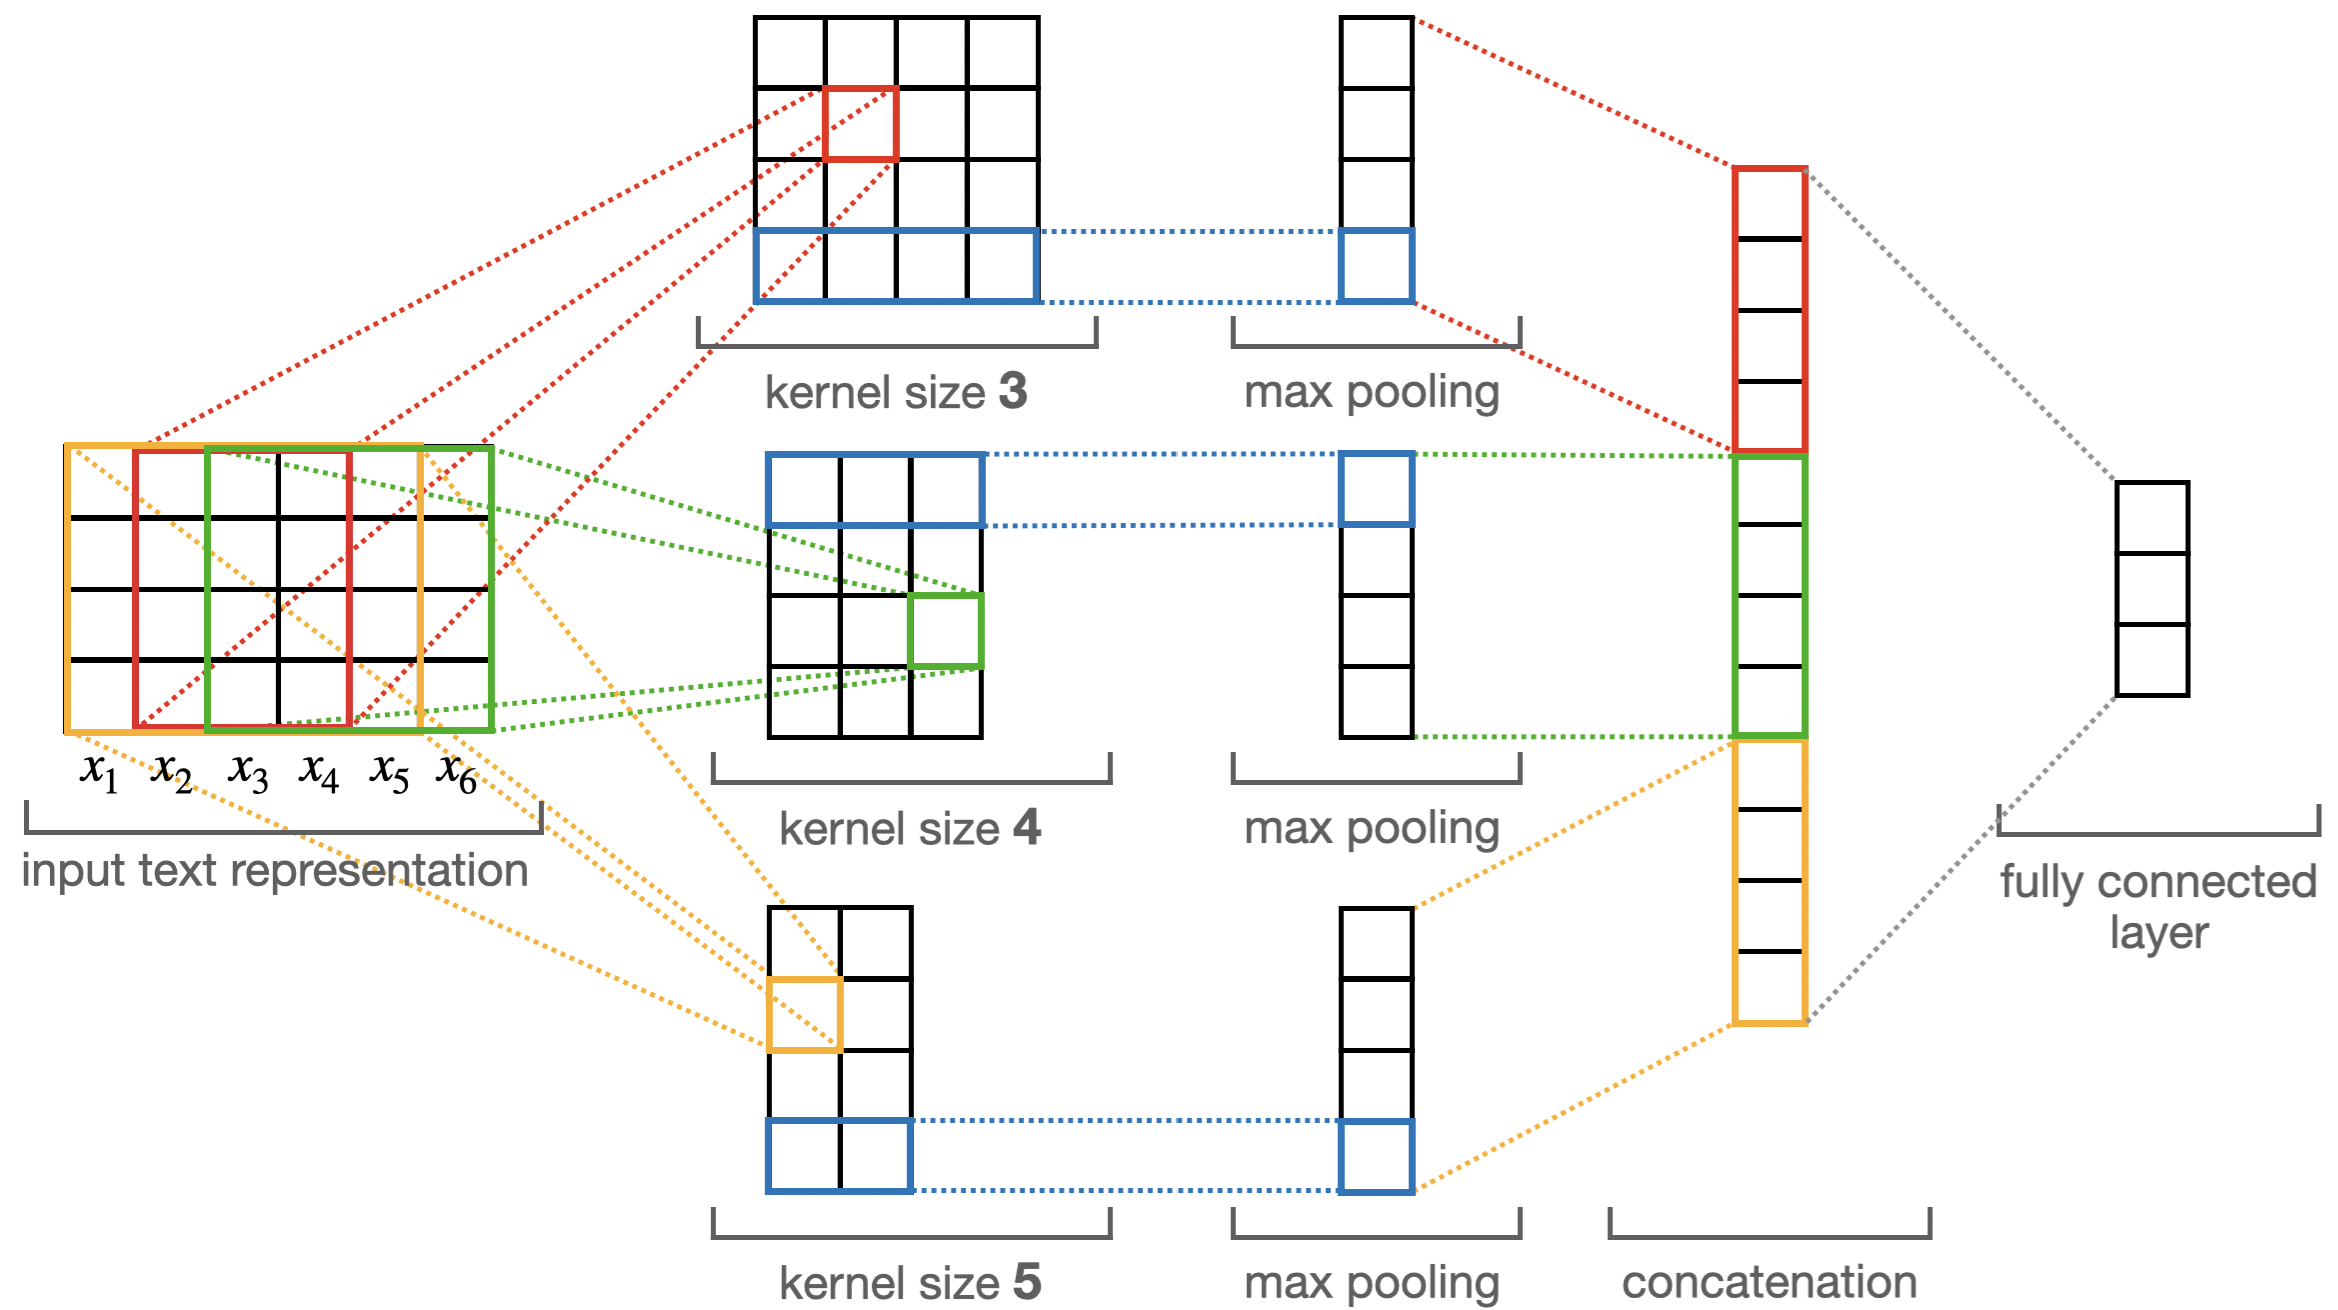


In [26]:
class TextCNN(nn.Module):
    def __init__(self, hid_dim=100, kernel_sizes=[3, 4, 5], n_classes=4):
        super().__init__()
            
        self.conv = nn.ModuleList([
            nn.Conv1d(in_channels=hid_dim, out_channels=hid_dim, kernel_size=k) for k in kernel_sizes
        ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(len(kernel_sizes) * hid_dim, n_classes)

    def forward(self, x):
        # x: [batch_size, seq_len, dim]
        # меняем местами размерности, так как число каналов (dim) должно стоять на втором месте
        x = x.permute(0, 2, 1)
        
        x = [self.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(self.dropout(x))
        return x

In [27]:
# инициализируем модель и переводим на GPU, если есть
model = TextCNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [28]:
wandb.init(project="nlp_lesson2", name="textcnn")

In [29]:
# учим в течение 5 эпох
for epoch in range(5):
    train(model, w2v_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader)

wandb.finish()

test_accuracy,▁▅▆▇█
test_loss,█▅▃▂▁
train_accuracy,▅▁▂▅▁▆▂▅▆▅▃▃▁▆▆▆▇▂▇▆▆▇▆▇▆▂█▅▅▇▅▇▅▆▆▅▅▃▅▅
train_loss,▆▂▃▅▄▃▂▃▂█▂▃▅▆▄▂▄▅▂▂▇▂▃▄▁▃▃▁▄▂▃▂▂▁▂▃▂▂▁▃
test_accuracy,0.90105
test_loss,0.28784
train_accuracy,0.9375
train_loss,0.2184


In [30]:
print('TextCNN')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

TextCNN
Test accuracy: 0.90105265
Test loss: 0.2878393773974753


## RNN

In [31]:
class SimpleRNN(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=128, n_classes=4, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim,
                          batch_first=True,
                          num_layers=num_layers)
        
        self.fc = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        # x: [seq_len, batch, input_dim]
        output, hidden = self.rnn(x)
        x = hidden[-1]  # take last hidden state
        return self.fc(x)


In [32]:
# инициализируем модель и переводим на GPU, если есть
model = SimpleRNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [33]:
wandb.init(project="nlp_lesson2", name="simple_rnn")

In [34]:
# учим в течение 5 эпох
for epoch in range(5):
    train(model, w2v_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, w2v_test_loader)

wandb.finish()

test_accuracy,▁▅▅▆█
test_loss,█▅▃▃▁
train_accuracy,▃▁▆▇▆▇▇▆▇▇▇▇▆▇▇█▇█▇█▇▇█▇▇▇█▆▇▆▇▇▇▇██▇▇▇▇
train_loss,▅█▅▆▃▅▆▅█▅▄▃▂▂▂▄▃▂▃▅▆▂▁▁▃▄▁▃▃▂▂▆▅▃▂▁▂▆▂▃
test_accuracy,0.90105
test_loss,0.28951
train_accuracy,0.96875
train_loss,0.1809


# Trainable Embeddings

To train embeddings, we need to **rebuild the dataset**.
Now, instead of using word embeddings directly (e.g., from Word2Vec), the dataset will contain **word indices** (integers).

The model will then learn a separate embedding vector for each index using an `nn.Embedding` layer.


In [35]:
# берем словарь из word2vec, чтобы он точно не изменился
vocabulary = w2v_model.index_to_key

In [36]:
# будем использовать для конвертации слов в индексы
word2id = {word: i for i, word in enumerate(vocabulary)}
word2id['[PAD]'] = len(word2id)

In [37]:
def text2ids(texts):
    # конвертируем все тексты в наборы индексов
    ids = []
    for words in texts:
        ids.append(torch.tensor([word2id[word] for word in words if word in word2id]))

    return ids

In [38]:
train_ids = text2ids(X_train)
test_ids = text2ids(X_test)
train_dataset = list(zip(train_ids, labels_train))
test_dataset = list(zip(test_ids, labels_test))

In [39]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # та же самая функция обработки батча
    # только теперь мы имеем дело с индексами, поэтому паддим индексом специального символа
    ids, labels = zip(*batch)
    return (
        pad_sequence(ids, padding_value=word2id['[PAD]']).permute(1, 0),
        torch.tensor(labels)
    )

In [40]:
from torch.utils.data import DataLoader

ids_train_loader = DataLoader(train_dataset, collate_fn=collate_fn, shuffle=True, batch_size=32)
ids_test_loader = DataLoader(test_dataset, collate_fn=collate_fn, shuffle=False, batch_size=8)

In [41]:
batch = next(iter(ids_train_loader))[0]

In [42]:
batch

tensor([[  352,  2810,   181,  ..., 27451, 27451, 27451],
        [ 2940,   324,    85,  ..., 27451, 27451, 27451],
        [ 1437,   347,  3666,  ..., 27451, 27451, 27451],
        ...,
        [  943,   722,  4737,  ..., 27451, 27451, 27451],
        [  355,    40,  1315,  ..., 27451, 27451, 27451],
        [  369,  1984,   933,  ..., 27451, 27451, 27451]])

In [43]:
class EmbeddingTextCNN(TextCNN):
    def __init__(self, vocab_size, hid_dim=100, kernel_sizes=[3, 4, 5], n_classes=4):
        super().__init__(hid_dim, kernel_sizes, n_classes)
        
        self.embedding = nn.Embedding(vocab_size, hid_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = super().forward(x)
        return x

In [44]:
# инициализируем модель и переводим на GPU, если есть
model = EmbeddingTextCNN(vocab_size=len(word2id)).to(device)

# ставим скорость обучения в 2 раза больше, потому что иначе эмбеддинги будут долго учиться
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-3)

In [45]:
wandb.init(project="nlp_lesson2", name="textcnn_train_embeddings")

In [46]:
# учим в течение 10 эпох, так как помимо модели нужно обучить слой эмбеддингов
for epoch in range(10):
    train(model, ids_train_loader, optimizer)
    test_accuracy, test_loss = evaluate(model, ids_test_loader)

wandb.finish()

test_accuracy,▁▃▅▇▇█████
test_loss,█▆▄▂▂▁▁▁▁▁
train_accuracy,▅▂▆▅▅▅▃▇▅▅▅▅█▅▅▅▁▅▆▆▇▇▅▅▆▇▇▇▆▅▆▅▅▆▆▅▅▇▄▅
train_loss,█▅▄▅▄▃▂▂▃▂▂▂▁▂▂▂▃▂▃▁▁▂▂▂▂▂▂▂▂▂▃▁▃▂▂▂▁▂▁▂
test_accuracy,0.91092
test_loss,0.26905
train_accuracy,0.90625
train_loss,0.26233


In [47]:
print('TextCNN train embeddings')
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

TextCNN train embeddings
Test accuracy: 0.91092104
Test loss: 0.2690506157592723


Almost matched the TF-IDF accuracy. But at what cost?

# BONUS: Prediction explanation

In practice, it's often very useful to understand **why** a model made a particular prediction. For simple models like linear regression or decision trees, interpretability is often built-in by design. However, for neural networks, things get more complex: the dependency between features and predictions is highly non-linear and opaque. As a result, we have to rely on various tricks to peek inside the model.

Some common approaches to do so:

* Perturb the input and observe how the prediction changes
* Search for examples that maximize or minimize the activation of specific neurons
  *([see more on this in distill.pub](https://distill.pub/2018/building-blocks/))*
* Fit a local linear approximation of the model
  (see the [LIME paper](https://arxiv.org/abs/1602.04938) and the [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters))
* Train an auxiliary neural network that learns to assign an importance score to each input word
  ([L2X paper](https://arxiv.org/abs/1802.07814))


For now, we'll focus on the **first approach**, as it's the most straightforward.

This means: we’ll slightly modify the input text (e.g., remove a word, replace it), and observe how the model’s prediction confidence changes — helping us estimate which words are most influential.

In [48]:
@torch.no_grad()
def explain(model, tokens, label):
    model.eval()
    token_ids = torch.cat(text2ids([tokens])).unsqueeze(0)

    baseline_pred = model(token_ids.to(device)).cpu()
    baseline_prob = torch.softmax(baseline_pred, dim=-1)[0, label]

    drop_one_batch = []
    for t in range(len(token_ids[0])):
        drop_one_token_ids = torch.hstack([token_ids[:, :t], token_ids[:, t+1:]])
        drop_one_batch.append(drop_one_token_ids)        

    drop_one_batch = torch.cat(drop_one_batch)
    
    drop_one_pred = model(drop_one_batch.to(device)).cpu()
    drop_one_prob = torch.softmax(drop_one_pred, dim=-1)[:, label]
    
    diffs = baseline_prob - drop_one_prob
    
    return list(zip(tokens, diffs))

In [49]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [50]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

In [51]:
i = 0
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, X_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Business


wall st bear claw back black reuters reuters short seller wall street dwindling band ultra cynic seeing green

In [52]:
i = 42
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, X_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Business


technology company sue five ex employee marlborough based technology company suing five former employee including three senior manager allegedly conspiring employer working opening competing business

In [53]:
i = 1000
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, X_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Sci/Tech


european union extends microsoft time warner review brussels belgium ap european antitrust regulator said monday extended review deal microsoft corp msft time warner inc

In [54]:
i = 1023
print(label_names[labels_train[i]])
tokens_and_weights = explain(model, X_train[i], labels_train[i])
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

Sports


olympics thorpe beat phelps u suffers gold gap athens reuters australian swimmer ian thorpe beat arch rival michael phelps men 200 meter freestyle monday united state trailed china australia japan medal table day three olympic game